# Objective of this notebook

The objective of this notebook is to try to show how do I think when I develop a ML model, this attempt will be done through a simple and complete approach to time-series problem with linear regression and Fourier series. For this, I will draw some dimensions this notebook will/won't cover:

- I will do an applied (and fictional) business case of this project. However, for this I will need to do some assumptions explained later.
- We will compare typical time-series base line models (last observation, historical mean, and historical median) vs multivariate linear regression (with deterministic processes)
- This notebook won't cover tree-based models as the final increase in performance obtained are sufficient for a business case application. However, in a future I will do a purely-technical approach comparing the models in this projects with tree-based models + trend (as tree based models don't overpolate), and LSTM.

That said, let's start!

# Business application

### Before start, I will do two strong assumptions:

1. As in business, usually we (as Data Scientists) aren't asked to predict something specific but, on the contrary, we face multiple business problems and business opportunities, where some of them could be solvable with machine learning (ML), where some of those that are solvable with ML could have some feasible solution, and maybe one of those feasible solutions could be worth of working on (a solution that's worth is just a solution which potential income is significantly higher than potential costs). So before getting this data, we are assuming that we already did that whole process.
2. The second assumption, is that once we have our business problem well defined, which means that we know that's solvable with ML, (potentially) feasible and (potentially) profitable.. we got the data ready!. We assume that we already have had plenty of meetings with the data team, BI team, business partner teams, in order to answer the question of the first assumption and to understand:
- Data: What's the data structure of the company? How is the data consistency throughtout time? What features can we use? Are those features available at the time of production?
- Using the ML model: How the ML model will be consumed? How much time pass between the business side receives our predictions and take some business action? How are we going to measure its real-time performance? Do we need continuous training or we will  do one-time training and we will update the ML model once the metrics performances are down from a pre-defined threshold?
- Business features: What features the business want to include? Those features fulfill the minimal requirements of consintency and avaliability to include them? 
- Missing data: Do we have missing data when building the datasets (train, test, hold-out, and implementation dataset)? If we have missing data, do we have any business insight to impute those missing values? We always can impute missing data with technical related techniques but usually we can find business-related reasons for the missing data and imputing them directly without any headache.

Given those two strong assumptions, we got a clean dataset and a confident level that the model we are going to develop and deploy is going to be used (if it adds value, of course).

### Now, let's start!

I picked up an airline monthly passengers dataset with the monthly quantity of passengers as the only variable from 1949 until 1960. But before we get into analyzing data and modeling, we have to ask first:

**What is the most appropriate metric model evaluation for this business problem?**

As we need to predict future demand, also we need to choose a metric to measure our technical performance. There is multiple metrics to measure regression models but the question we need to answer is: what's the evaluation metric that makes more sense for this business problem? 

Airlines are allowed to overbook and bumping, in this [US Department of Transportation site](https://www.transportation.gov/individuals/aviation-consumer-protection/bumping-oversales) we can read plenty of advantages for airlines to overbooking and bump passengers. If we get into the airlines perspective given this context, we are facing the decision trade-off of not overbooking and risking a flight with empty seats, or overbooking and risking giving compensations to passengers bumped. Given that airlines tend to overbook, we can assume that airlines prefer to risk to compensate for a passenger bumped, which means that for airlines is more costly to fly with empty seats than an overbooked flight risking paid compensations. With this, we can say that is more costly for an airline to underestimate demand than to overestimate demand. The mean squared logarithmic error (MSLE) is a regression evaluation metric that penalizes underestimates more than overestimates, which goes in line with the airlines decision trade-off we just discussed. Hence, we will use **MSLE as our main decision metric**, and we will take **mean absolute error (MAE)** and **mean squared error (MSE)** as a reference metrics evaluations.

Having decided on that, let's start with the setup

# Set-up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_log_error as MSLE, mean_squared_error as MSE, mean_absolute_error as MAE
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

pd.set_option('display.max_columns', 100)

#### Functions created for this project

In [2]:
def ts_train_test_split(X_data, y_data, cols):
    '''
    This functions does a time series split where the last two years 
    will be the test set, and all the years before will be the training set
    '''
    latest_two_years = X_data.index.year.unique().sort_values()[-2:]
    
    train_mask = ~X_data.index.year.isin(latest_two_years)
    test_mask = X_data.index.year.isin(latest_two_years)
    
    X_train = X_data.loc[train_mask, cols]
    y_train = y_data[train_mask]
    X_test = X_data.loc[test_mask, cols]
    y_test = y_data[test_mask]
    
    return(X_train, y_train, X_test, y_test)

def metrics_computation(y_train, y_pred_train, y_test, y_pred_test):
    '''
    This function compute each of the three different
    metrics (MSLE, MSE, MAE) we defined, for each model we try.
    '''
    error_train = (y_train-y_pred_train).rename('Train Error')
    error_test = (y_test-y_pred_test).rename('Test Error')
    
    mae_train = MAE(y_train, y_pred_train).round(5)
    mae_test = MAE(y_test, y_pred_test).round(5)
    
    mse_train = MSE(y_train, y_pred_train).round(5)
    mse_test = MSE(y_test, y_pred_test).round(5)
    
    msle_train = MSLE(y_train, y_pred_train).round(5)
    msle_test = MSLE(y_test, y_pred_test).round(5)
    
    error_train_div = (y_train/y_pred_train).rename('Train Error')
    
    df_errors = pd.DataFrame({'metrics': ['MSLE train', 'MSLE test','MSE train', 'MSE test', 'MAE train', 'MAE test'],
                  'values': [msle_train, msle_test, mse_train, mse_test, mae_train, mae_test]})
    
    return error_train, error_test, mae_train, mae_test, mse_train, mse_test, msle_train, msle_test, df_errors

def plot_metrics_model(cols, y_data, y_pred_train, y_pred_test, error_train, error_test,
                       msle_train, msle_test, mse_train, mse_test, mae_train, mae_test, df_errors, title=None):
    """
    This  function plots the train and test error 
    we computed in the metrics_computation function.
    """
    fig = plt.figure(figsize=(18,4))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(223)
    ax3 = fig.add_subplot(122)
    
    ax3.table(cellText=df_errors.values, colLabels=df_errors.columns, loc='center')
    
    fig.suptitle(f'{title}; Columns used: {cols}') 
    ax1 = y_data.plot(label='Original data', ax=ax1, c='blue')
    ax1 = y_pred_train.plot(ax=ax1, c='orange')
    ax1 = y_pred_test.plot(ax=ax1, c='orange', linestyle='--')
    ax1.legend()
    ax1.set_xticks([])
    ax1.set_xlabel('')

    ax2 = error_train.plot(label='Train error', ax=ax2)
    ax2 = error_test.plot(label='Test error', ax=ax2, linestyle='--')
    ax2.legend()
    ax3.axis('off')
    plt.show()

# Read the data

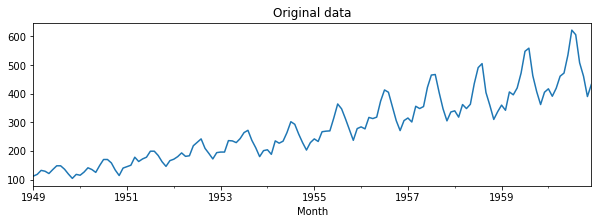

,Pax
Month,
1949-01,112
1949-02,118
1949-03,132


Total missing values in the dataset: 0


In [3]:
df_airps = pd.read_csv('input/AirPassengers.csv')
df_airps.columns = ['Month', 'Pax']
df_airps.index = pd.to_datetime(df_airps.Month).dt.to_period('M')
df_airps = df_airps.drop('Month', axis=1)
df_airps.Pax.plot(figsize=(10,3))
plt.title('Original data')
plt.show()
y = df_airps.squeeze().rename('Y')
display(df_airps.head(3))
print('Total missing values in the dataset:', df_airps.isnull().sum().sum())

The data consist of monthly air passengers. We can see that the time series data is multiplicative, has annual seasonality, a positive trend (more linear than squared seems to be), and no missing values.

We will assess our dependent variable with:
- **Periodogram**: It will tell us the stationality frequency (which from the plot above we can see it's likely will be annual).
- **Partial autocorrelation**: It measures the residual correlation between lags features and the dependent variable (Y) once the influence of the most recent lags is removed. For example, given that lag_3 represent the dependent variable (Y) lagged 3 periods, and their partial correlation is the correlation between lag_3 and Y removing the influence of the correlation between Y_1 and Y, and the partial correlation between Y_2 and Y, where the partial correlation between Y_2 and Y is the correlation between Y and Y_2 minus the influence of the correlation between Y and Y_1. 

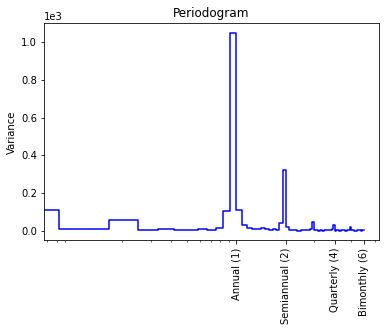

In [4]:
def plot_periodogram(ts, fs):
    '''
    This function plots the signal strenght distribution 
    of the time series through time
    '''
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend='linear',
        window="boxcar",
        scaling='spectrum',
    )
    _, ax = plt.subplots()
    ax.step(frequencies, spectrum, color="blue")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            #"Monthly (12)",
            #"Biweekly (26)",
            #"Weekly (52)",
            #"Semiweekly (104)",
        ],
        rotation=90,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    plt.show()

plot_periodogram(y, 12)

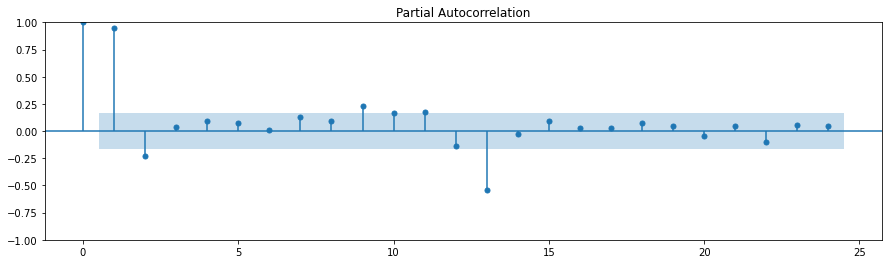

In [5]:
fig, ax = plt.subplots(figsize=(15,4))
plot_pacf(y, method= 'ywm',lags = 24, ax=ax)
plt.show()

From the plots above, we can seee that we have a strong annual seasonality and a significant partial autocorrelation of our dependent variable with lags 1, 2, 9 and 13. If we werent sure that our series is stationary we could apply the [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test), which is a statistical hypothesis test that allows us to detect stationarity.

# Feature engineering

Given the analysis above, we will do create the next features:
- `Y_Lag1`, `Y_Lag2`, `Y_Lag9`, `Y_Lag13`: The dependent variable lagged for the periods we found in the periodogram. Y_Lag1 is our last observation baseline model.
- `Y_median_12m`: The rolling median for 12 periods before, this is ous historial median baseline model
- `Y_mean_12m`: The rolling mean for 12 periods before, this is our historical mean baseline model
- `const`, `trend`, and `trend_squared`: the constant is needed as we using linear regression and we have certainty that the prediction doesn't start at the origin. trend and trend_squared because I can't see if the time series is better fitted with a straight line or a mix of straight and trend squared.
- Seasonal variables: For annual seasonality buy for each month
- `Fourier` series: A fourier series of one frequency per year, as we saw in the plot we have an annual seasonality.
- `sin_tr`, `cos_tr`: Fourier series multiplied by the trend, this will allow us to capture the multiplicative effect.
- `sin_m12w`, `cos_m12w`: Idem, but multiplied by the historical mean (as the historical mean is better to capture when the trend is not straight).

At work we could be creative and get some independent features. For example, could be nice to have the [US consumer confidence index](https://www.conference-board.org/topics/consumer-confidence) as it's a leading indicator about consumption intentions of the US citizen.

In [6]:
X = pd.DataFrame(y.shift(1).bfill().rename('Y_Lag1'))
X['Y_Lag2'] = y.shift(2).bfill()
X['Y_Lag9'] = y.shift(9).bfill()
X['Y_Lag13'] = y.shift(13).bfill()
X['Y_median_12m'] = y.rolling(window=12, min_periods=3).median().shift(1).bfill() # We need to shift the data as the laterolling
X['Y_mean_12m'] = y.rolling(window=12, min_periods=3).mean().shift(1).bfill()


dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=2, # Trend and trend squared
        seasonal=True, # Seasonal variables
        additional_terms=[CalendarFourier(freq="Y", order=1)], # Fourier series
        drop=True,
    )

X = pd.merge(X, dp.in_sample(), left_index=True, right_index=True, how='left')

cols_fourier = ['sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)']

X = X.rename(columns = {'sin(1,freq=A-DEC)':'sin', 'cos(1,freq=A-DEC)':'cos'})
X['sin_tr'] = X.trend*X.sin
X['cos_tr'] = X.trend*X.cos
X['sin_m12w'] = X.Y_mean_12m*X.sin
X['cos_m12w'] = X.Y_mean_12m*X.cos
seasonal_cols = ['s(2,12)','s(3,12)','s(4,12)','s(5,12)','s(6,12)',
                 's(7,12)','s(8,12)','s(9,12)','s(10,12)','s(11,12)','s(12,12)']
pd.concat([X,y], axis=1).head(3)

,Y_Lag1,Y_Lag2,Y_Lag9,Y_Lag13,Y_median_12m,Y_mean_12m,const,trend,trend_squared,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)",sin,cos,sin_tr,cos_tr,sin_m12w,cos_m12w,Y
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,
1949-01,112.0,112.0,112.0,112.0,118.0,120.666667,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,120.666667,112
1949-02,112.0,112.0,112.0,112.0,118.0,120.666667,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508671,0.860961,1.017342,1.721922,61.379627,103.889296,118
1949-03,118.0,112.0,112.0,112.0,118.0,120.666667,1.0,3.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.849817,0.527078,2.549451,1.581233,102.544596,63.600710,132


Just for demonstratation purposes, we will see how the frequency our Fourier series fits the time series detrended

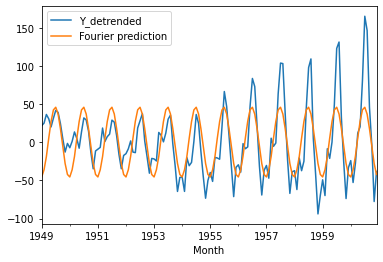

In [7]:
data = DeterministicProcess(
        index=y.index,
        constant=True,
        order=1, # Trend and trend squared
        seasonal=False,
        additional_terms=[CalendarFourier(freq="Y", order=1)], # Fourier series, one frequency per year
        drop=True,
    ).in_sample()
data

model = LinearRegression(fit_intercept=False).fit(data[['const', 'trend']], y)
y_pred = pd.Series(model.predict(data[['const', 'trend']]), index=data.index, name='Y_pred')
y_detrended = y-y_pred

model = LinearRegression(fit_intercept=False).fit(data[['const', 'sin(1,freq=A-DEC)','cos(1,freq=A-DEC)']], y_detrended)
y_pred = pd.Series(model.predict(data[['const', 'sin(1,freq=A-DEC)','cos(1,freq=A-DEC)']]), index=data.index, name='Y_pred')

y_detrended.plot(label='Y_detrended')
y_pred.plot(label='Fourier prediction')
plt.legend()
plt.show()

We can see that the fourier series fit nicely the frequency seasonality but still requires an incremental factor to fit better the time series data, that's why we are multipliying the fourier series with the trend in the feature engineering step.

### Time-series split discussion

At the beginning of this notebook I created the function `ts_train_test_split()` which separates the train and test data, giving the test data the last two years and the rest of the years the training set.

In real-life projects **we split the data in line the business requirements** as feasible it can be. Does the business need yearly, monthly, weekly, or daily predictions? (In this project we couldn't do higher than monthly prediction as our data period is in months, so we would need to ask data with the level of granularity that the business requires). After we define the frequency which we will make our predictions (and hence we will split the data given that criteria), we need to ask ourselves: **how much time needs the business from receiving our input to executing business actions?** We could have no delay in our data availability for production**[1]** but if the business needs one week to plan those actions, we need to consider that week when we are modeling as it will impact in our model in production. 

For example, if we are able to deliver monthly predictions each 30th on each month, and the business takes 10 days to take action after receiving our input, our predictions would be impacting the business from 10th on the month after we delivered our predictions, missing those 10 days we  predicted. So, to make a correct implementation in this example, we would have to deliver the prediction each 20th of each month, so the business uses the have those 10 needed days to take someaction on the 1st of the next month. 

**[1]** Having no delay in our data availibility for production means that all of our features are available the day we deliver the predictions to the business. For example, sometimes you can have a delay because the banking data (assuming you have a feature from banking data) every month is uploaded to the databases the 8th of the next month. Hence, you can't predict for 1st to 30th of September using the data of August because that data won't be available then we do the predicitons. You will have to predict with the data of July, having one month delay in your data availability.

# Baseline models: historical mean, historical median, and last observation

Here we build the three baseline models and their respective errors.

In [8]:
def mdl_baseline(X_data, y_data, cols, title, ret=False):
    '''
    It computes, calculates, and plot the baseline model.
    '''
    X_train, y_train, X_test, y_test = ts_train_test_split(X_data, y_data, cols)
    
    y_pred_train = X_train[cols].squeeze()
    y_pred_test = X_test[cols].squeeze()
    
    error_train, error_test, mae_train, mae_test, mse_train, mse_test, msle_train, msle_test, df_errors = metrics_computation(y_train, y_pred_train, y_test, y_pred_test)

    plot_metrics_model(cols, y_data, y_pred_train, y_pred_test, error_train, error_test,
                       msle_train, msle_test, mse_train, mse_test, mae_train, mae_test, df_errors, title)
    
    if ret==True:
        return(df_errors)

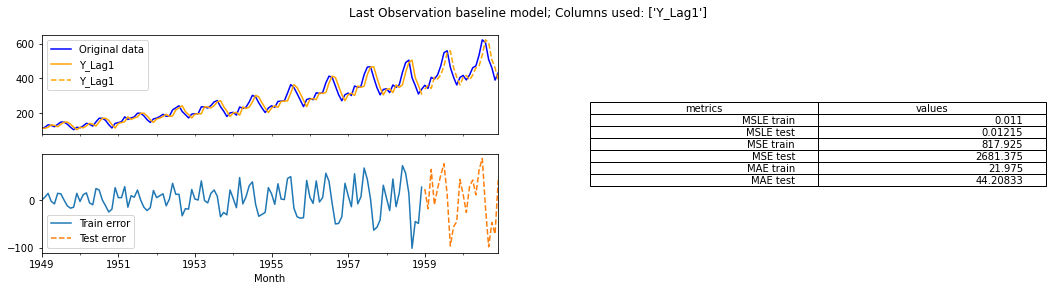

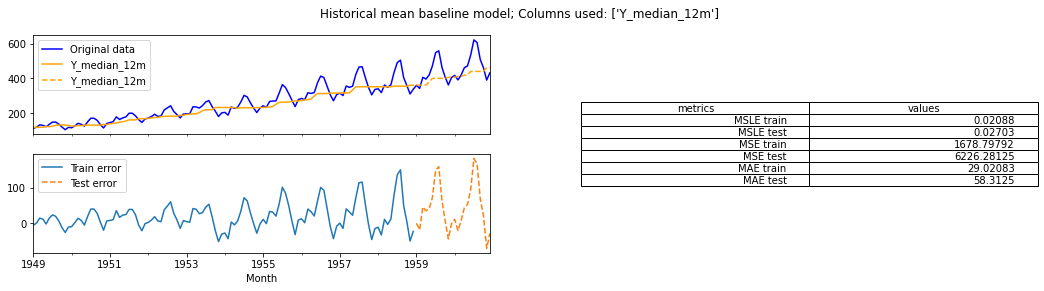

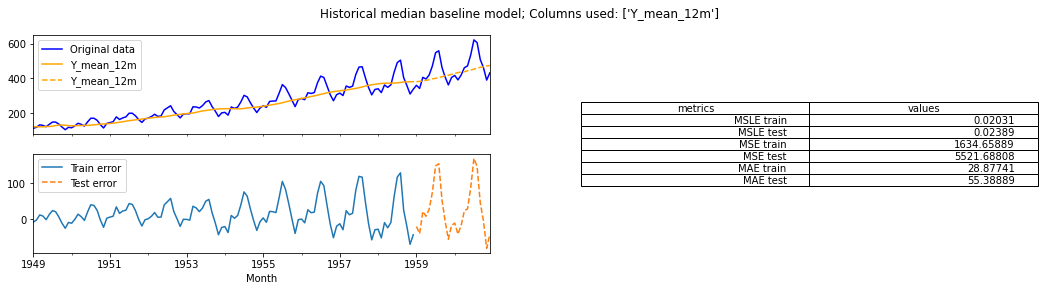

In [9]:
errors_lo = mdl_baseline(X, y, ['Y_Lag1'], 'Last Observation baseline model', ret=True)
errors_hmean = mdl_baseline(X, y, ['Y_median_12m'], 'Historical mean baseline model', ret=True)
errors_hmedian = mdl_baseline(X, y, ['Y_mean_12m'], 'Historical median baseline model', ret=True)

We can see above that our best baseline model is the Last Observation, with MSLE 1.1% in train and 1.2% in test.

# Model Linear Regression

In [10]:
def mdl_linear_reg(X_data, y_data, cols, title, ret=False):
    '''
    This function will allow us to efficiently do multiple linear regression
    models with only choosing the variables we want to use as the functions
    splits the data in train and test, train the model with the training data
    and predict the test set using only the columns we choose, and lastly it plots
    the errors of the predictions and returns (if we choose that way) the trained
    model and a dataframe with train and test errors.    
    '''
    X_train, y_train, X_test, y_test = ts_train_test_split(X_data, y_data, cols)
    
    model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
    y_pred_train = pd.Series(
            model.predict(X_train),
            index=X_train.index,
            name='Y_pred_train')
    y_pred_test = pd.Series(
            model.predict(X_test),
            index=X_test.index,
            name='Y_pred_test')
    
    error_train, error_test, mae_train, mae_test, mse_train, mse_test, msle_train, msle_test, df_errors = metrics_computation(y_train, y_pred_train, y_test, y_pred_test)

    plot_metrics_model(cols, y_data, y_pred_train, y_pred_test, error_train, error_test,
                       msle_train, msle_test, mse_train, mse_test, mae_train, mae_test, df_errors, title)

    if ret==True:
        return(model, df_errors)

### First iteration

- Model 1: `constant`, `trend` 
- Model 2: `constant`, `trend_squared`

We can see that model 1 has a lower MSLE, and the remaining error follows an annual seasonality. Hence, we will keep the trend.

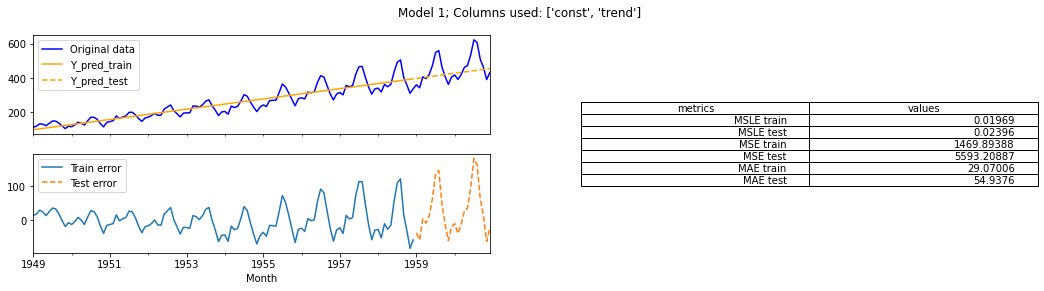

In [11]:
mdl_linear_reg(X, y, ['const','trend'], 'Model 1')

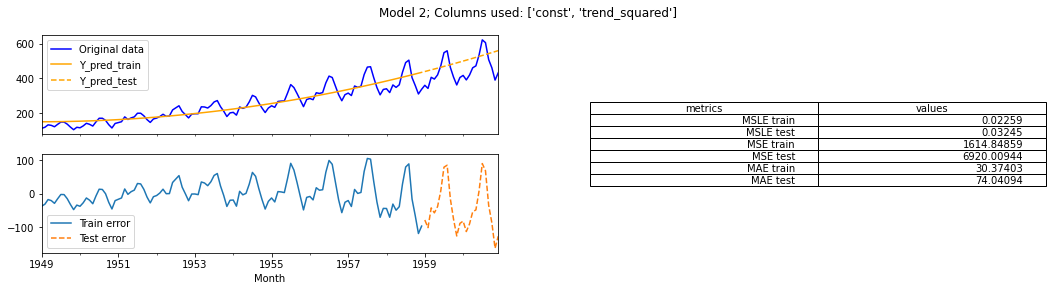

In [12]:
mdl_linear_reg(X, y, ['const','trend_squared'], 'Model 2')

### Second iteration: 

#### Common variables: `const`, `trend`

- Model 3: Common varibles + seasonal columns
- Model 4: Common variables + fourier series
- Model 5: Common variables + fourier series multiplied by linear trend

Here the model 5 has the lower MSLE for train and test, but what if we add to it the seasonal columns to give it more flexibility to the fit? We will try this with **Model 6**.

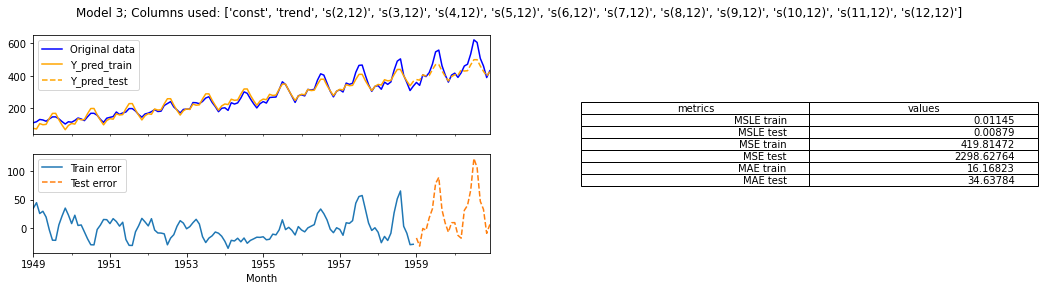

In [13]:
mdl_linear_reg(X, y, ['const','trend'] + seasonal_cols, 'Model 3')

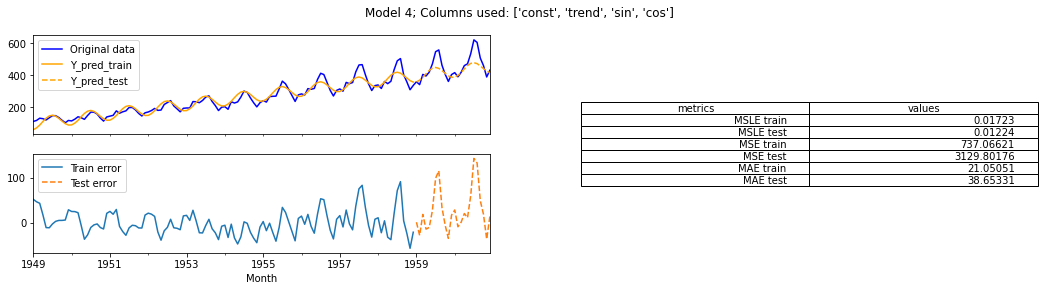

In [14]:
mdl_linear_reg(X, y, ['const','trend','sin','cos'], 'Model 4')

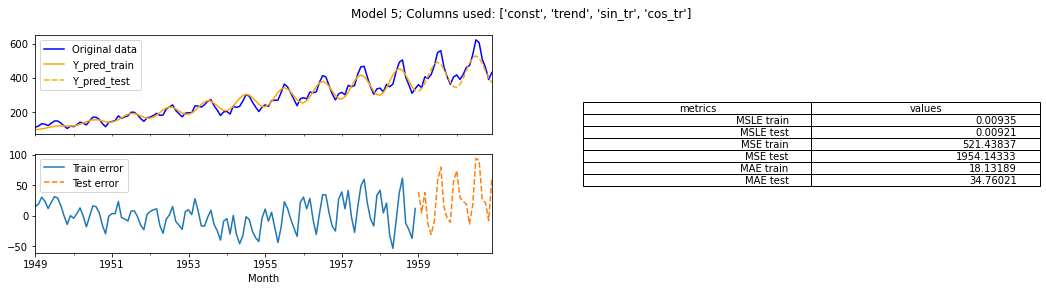

In [15]:
mdl_linear_reg(X, y, ['const','trend','sin_tr','cos_tr'], 'Model 5')

### Third iteration

#### Common variables: `const`

- Model 6: trend + Fourier series multiplied by trend + seasonal columns
- Model 7: historical mean + Fourier series multiplied by trend + seasonal columns
- Model 8: historical mean + Fourier series multiplied by historical mean + seasonal columns

When we change the trend (Model 6) with the historical mean (Model 7), we see a significant improvement. If we go a bit further and use Fourier series multiplied by historical mean (Model 8) instead that multiplied by trend (Model 7), we see asmall  improvement in the metrics.

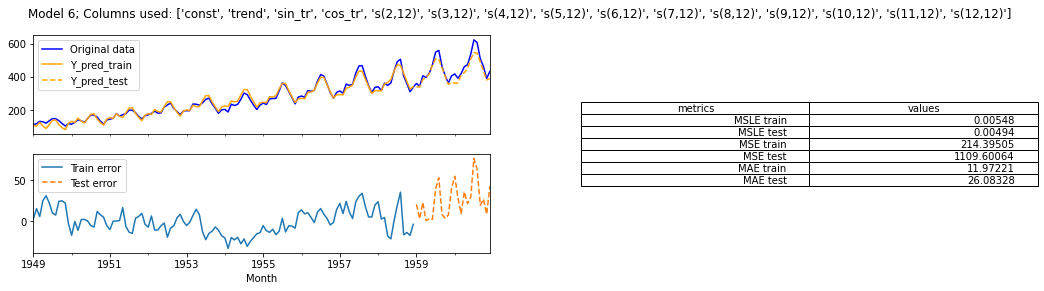

In [16]:
mdl_linear_reg(X, y, ['const','trend','sin_tr','cos_tr'] + seasonal_cols, 'Model 6')

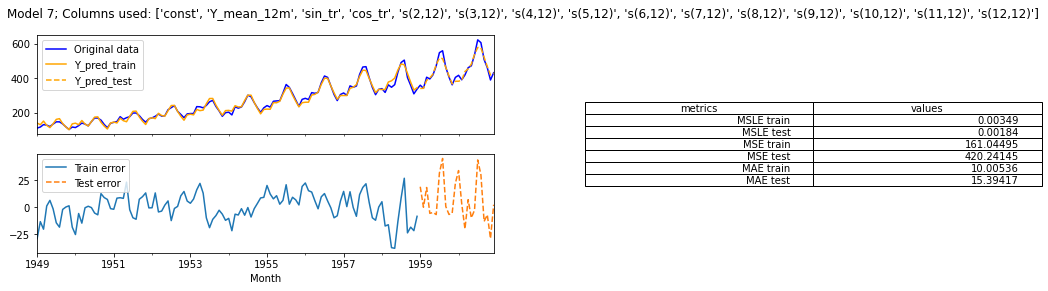

In [17]:
mdl_linear_reg(X, y, ['const','Y_mean_12m','sin_tr','cos_tr'] + seasonal_cols, 'Model 7')

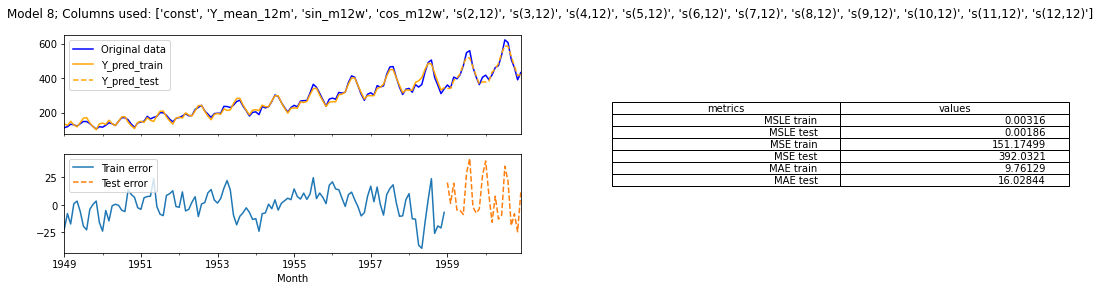

In [18]:
mdl_linear_reg(X, y, ['const','Y_mean_12m','sin_m12w','cos_m12w'] + seasonal_cols, 'Model 8')

#### Given these results, we will pick Model 8 as the final model and compare it with the baseline model

# Baseline vs Final model 8

We get the errors table for the final model

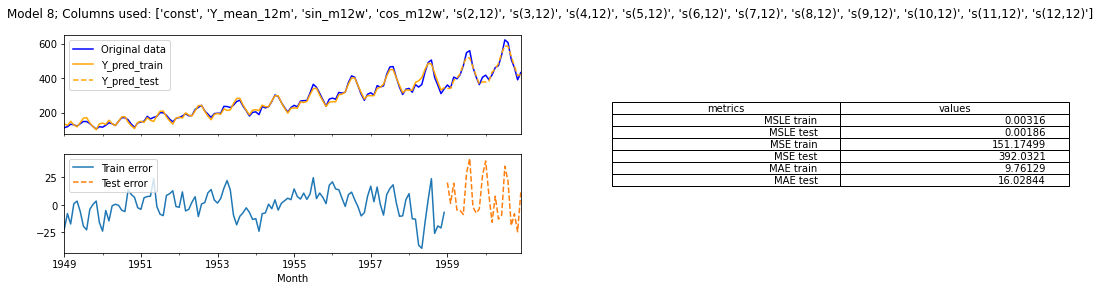

In [19]:
best_lr, errors_lr = mdl_linear_reg(X, y, ['const','Y_mean_12m','sin_m12w','cos_m12w'] + seasonal_cols, 'Model 8', ret=True)

### Error comparison

We consolidate the different table errors in one dataframe

In [20]:
df_errors = pd.concat([errors_lo.assign(model='Last obs'),
                       errors_hmean.assign(model='Historical mean'),
                       errors_hmedian.assign(model='Historical median'),
                       errors_lr.assign(model='linear regression')])
df_errors['metric'] = df_errors['metrics'].str.split(' ', expand=True)[0]
df_errors['dataset'] = df_errors['metrics'].str.split(' ', expand=True)[1]
mask = df_errors.metric == 'MSLE'
df_errors[mask]

,metrics,values,model,metric,dataset
0,MSLE train,0.01100,Last obs,MSLE,train
1,MSLE test,0.01215,Last obs,MSLE,test
0,MSLE train,0.02088,Historical mean,MSLE,train
1,MSLE test,0.02703,Historical mean,MSLE,test
0,MSLE train,0.02031,Historical median,MSLE,train
1,MSLE test,0.02389,Historical median,MSLE,test
0,MSLE train,0.00316,linear regression,MSLE,train
1,MSLE test,0.00186,linear regression,MSLE,test


In [21]:
print('Our Model 8 is better than the best baseline train (Last Obs) in:',round((0.01100-0.00316)/.01100,3)*100,'%')
print('Our Model 8 is better than the best baseline test (Last Obs) in:',round((0.01215-0.00186)/0.01215,3)*100,'%')

Our Model 8 is better than the best baseline train (Last Obs) in: 71.3 %
Our Model 8 is better than the best baseline test (Last Obs) in: 84.7 %


#### Here we plot the three baselined model errors and the errors of the final Model 8.

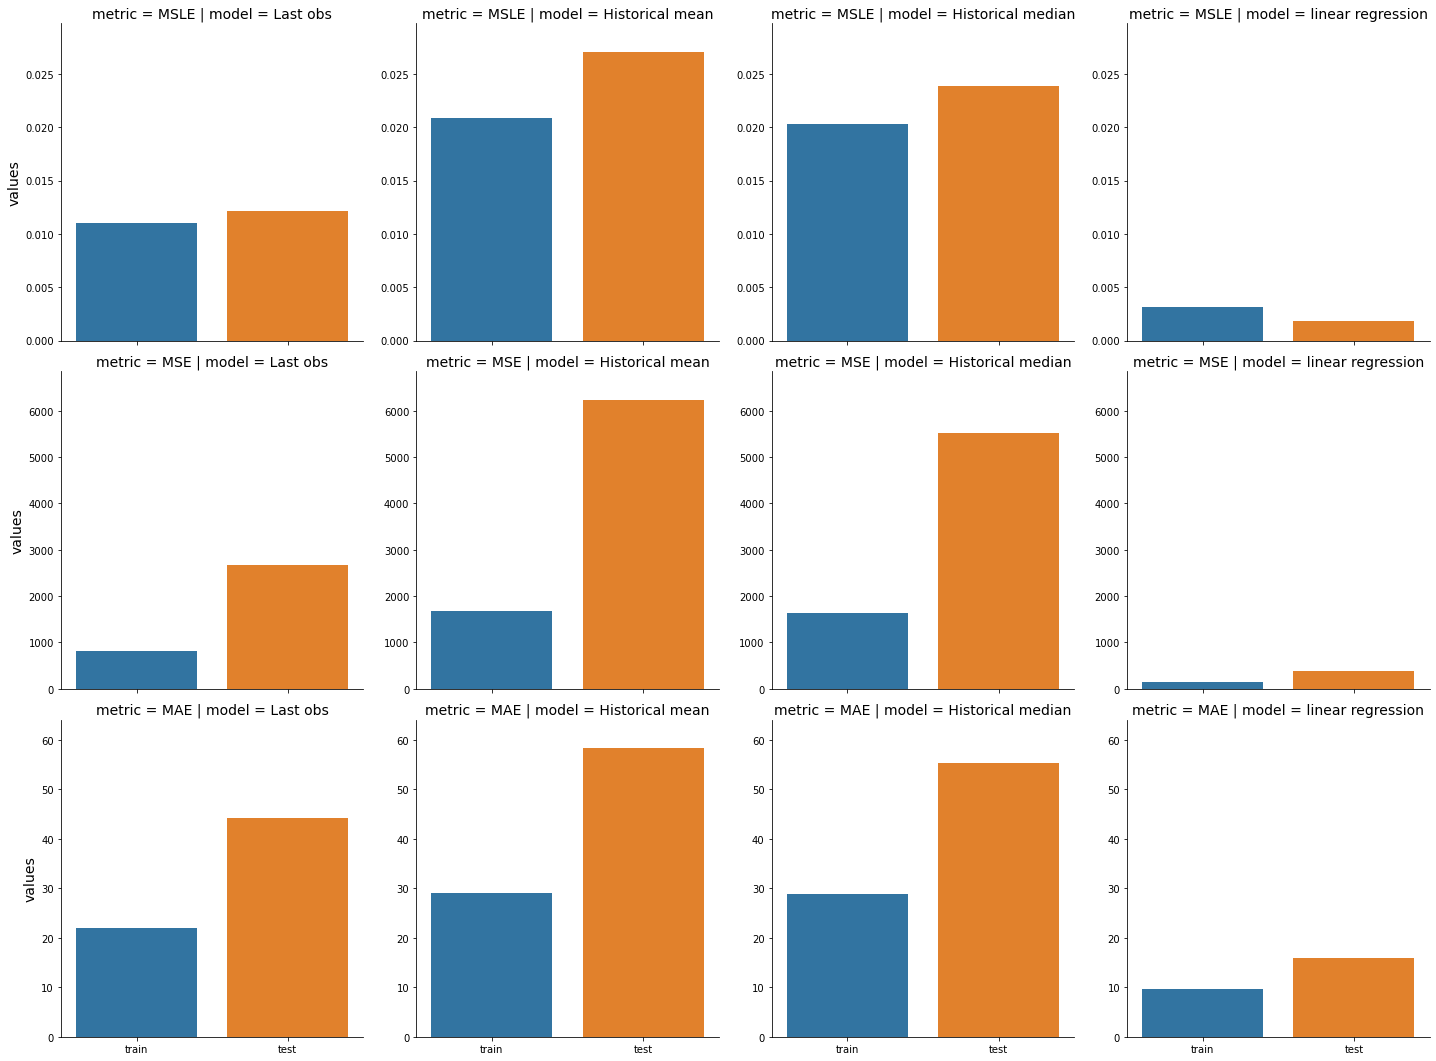

In [22]:
max_value_MSLE_plots = df_errors.loc[df_errors.metric == 'MSLE', 'values'].max()*1.1
max_value_MSE_plots = df_errors.loc[df_errors.metric == 'MSE', 'values'].max()*1.1
max_value_MAE_plots = df_errors.loc[df_errors.metric == 'MAE', 'values'].max()*1.1

g = sns.catplot(kind='bar', data=df_errors, x='dataset', y='values', col='model', row='metric', sharey=False)
[g.axes[0][i].set_ylim(0,max_value_MSLE_plots) for i in range(0,4)]
[g.axes[1][i].set_ylim(0,max_value_MSE_plots) for i in range(0,4)]
[g.axes[2][i].set_ylim(0,max_value_MAE_plots) for i in range(0,4)]
for i in g.axes:
    for k in i:
        title = k.get_title()
        k.set_title(title, size=14)
        k.set_xlabel(None)
        
        y_label = k.get_ylabel()
        k.set_ylabel(y_label, size=14)
plt.show()

# Conclusions

We ended  with a final model that improves the performance of the baseline model by more than 70%. I stopped there because it's a significant increase, we could have tried further, like using a tree-based model 

In real-life scenarios usually the baseline model is the alternative the business currently executes (e.g. how today they are predicting demand). For example, if they predict montly demand thorugh different analysis and they run those analysis every month, the performance of those analysis is the alternative we should compare the performance of our Model 8. 

At a personal level, I like to present these results with business metrics. For example, how much increase in income represents that 70% increase in performance over the baseline model? How do we explain this model from a business perspective? We can take the coefficients of the final model and explain the impact of each feature in the dependent variable.